## Setup

In [1]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [2]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib
#from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


2025-08-05 03:28:47.859 | INFO     |  Running on cpu


In [3]:
task = 'BlockTableRed'
path = data_root / task / 'demos'

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)
print(scene_data.sample_data_point_with_ground_truth(cam="wrist"))


2025-08-05 03:28:53.796 | INFO     |  Loading dataset(s): 
2025-08-05 03:28:53.797 | INFO     |    Initializing datasete using /home/jangruhnert/Projects/TapasCalvin/data/BlockTableRed/demos/metadata.json
2025-08-05 03:28:53.802 | INFO     |    Extracted gt object labels [0, 1, 2, 3, 4, 5, 6]
2025-08-05 03:28:53.803 | INFO     |    Extracted tsdf object labels []
2025-08-05 03:28:53.803 | INFO     |    Done! Data contains 5 trajectories.
SingleCamSceneObservation(
    action=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    depth=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
    ee_pose=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    extr=Tensor(shape=torch.Size([4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
    feedback=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
    intr=Tensor(shape=torch.Size([3, 3]), device=cpu, dtype=t

In [4]:
gt_pose_config = {}

gt_kp_config = {
    'encoder_name': 'demos_keypoints_gt_encoder-world',
    'cam': 'static',
}

kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'gtcopy',
}


In [5]:
observations = scene_data.get_demos(**gt_pose_config)
print(observations[0].keys())
print(observations[0])
n_obs = len(observations)

demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=False,
    kp_indeces=None,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True
)

demos = Demos(observations, **data_kwargs)
print(demos)

_LazyStackedTensorDictKeysView(['action', 'cameras', 'ee_pose', 'feedback', 'gripper_state', 'joint_pos', 'joint_vel', 'object_poses', 'object_states'],
    include_nested=False,
    leaves_only=False)
SceneObservation(
    action=Tensor(shape=torch.Size([163, 7]), device=cpu, dtype=torch.float32, is_shared=False),
    cameras=LazyStackedTensorDict(
        fields={
            _order: CameraOrder(
                order=('wrist',),
                batch_size=torch.Size([163]),
                device=None,
                is_shared=False),
            wrist: SingleCamObservation(
                depth=Tensor(shape=torch.Size([163, 256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
                extr=Tensor(shape=torch.Size([163, 4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
                intr=Tensor(shape=torch.Size([163, 3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                rgb=Tensor(shape=torch.Size([163, 3, 256, 256]), device=cpu, dt

In [6]:
tpgmm_config = TPGMMConfig(
    n_components=10,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=False,
    add_gripper_action=True,
    reg_shrink=1e-2,
    reg_diag=2e-4,
    reg_diag_gripper=2e-2,
    reg_em_finish_shrink=1e-2,
    reg_em_finish_diag=2e-4,
    reg_em_finish_diag_gripper=2e-2,
    trans_cov_mask_t_pos_corr=False,
    em_steps=50,
    fix_first_component=True,
    fix_last_component=True,
    reg_init_diag=5e-4,  # 5
    heal_time_variance=False,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.5,
    use_bic=False,
    drop_redundant_frames=False,
)

demos_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,
    repeat_final_step=10,
    repeat_first_step=0,
    components_prop_to_len=True,
    min_n_components=1,
    min_end_distance=20
)

cascade_config = CascadeConfig(
    kl_keep_time_dim=True,
    kl_keep_rotation_dim=False,
)

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demos_segmentation_config,
    cascade=cascade_config,
)

In [7]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2025-08-05 03:29:07.969 | INFO     |  Fitting AutoTPGMM
2025-08-05 03:29:07.969 | INFO     |  Performing fitting actions: [INIT]
2025-08-05 03:29:07.969 | INFO     |  Segmenting trajectories


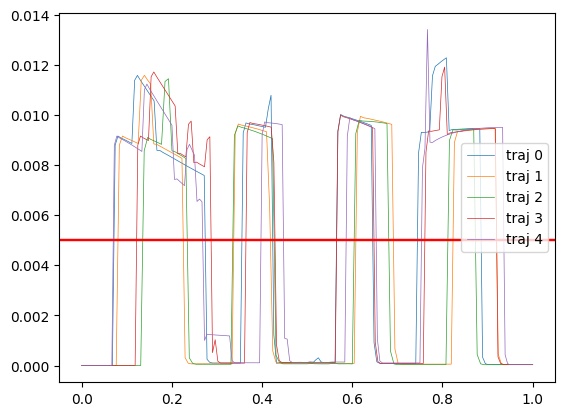

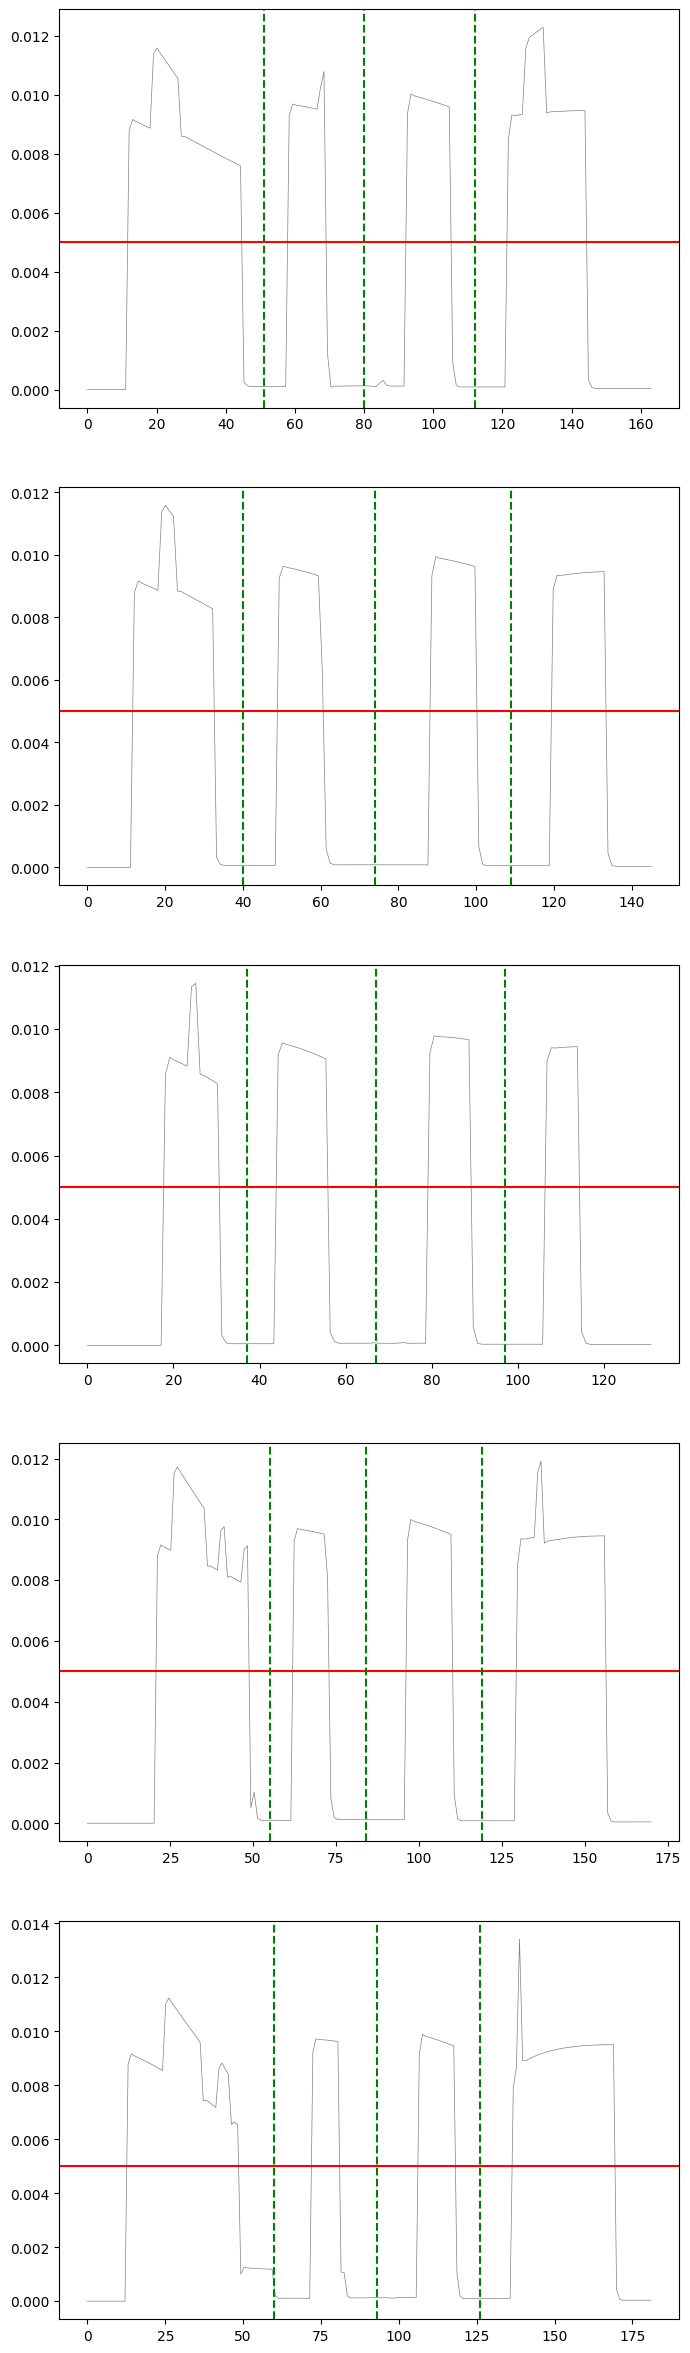

2025-08-05 03:29:09.860 | INFO     |  Creating segement of demos.
2025-08-05 03:29:09.871 | INFO     |  Subsampling to length 57 using strategy mean-length.
2025-08-05 03:29:09.873 | INFO     |  Creating segement of demos.
2025-08-05 03:29:09.883 | INFO     |  Subsampling to length 40 using strategy mean-length.
2025-08-05 03:29:09.886 | INFO     |  Creating segement of demos.
2025-08-05 03:29:09.897 | INFO     |  Subsampling to length 42 using strategy mean-length.
2025-08-05 03:29:09.898 | INFO     |  Creating segement of demos.
2025-08-05 03:29:09.909 | INFO     |  Subsampling to length 54 using strategy mean-length.
2025-08-05 03:29:09.910 | INFO     |  ... created 4 segments
2025-08-05 03:29:09.911 | INFO     |    Fitting candidate frame 1/10
2025-08-05 03:29:09.911 | INFO     |    Creating partial frame view of demos.
2025-08-05 03:29:09.920 | INFO     |    Manifold: TIME x R3 x QUAT x R1
2025-08-05 03:29:09.920 | INFO     |    Changing number of components to 2
2025-08-05 03:29:

Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:29:10.148 | INFO     |    Fitting candidate frame 2/10
2025-08-05 03:29:10.148 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:29:10.476 | INFO     |    Fitting candidate frame 3/10
2025-08-05 03:29:10.477 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:29:10.841 | INFO     |    Fitting candidate frame 4/10
2025-08-05 03:29:10.841 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:29:11.139 | INFO     |    Fitting candidate frame 5/10
2025-08-05 03:29:11.140 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:29:11.417 | INFO     |    Fitting candidate frame 6/10
2025-08-05 03:29:11.417 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:29:11.688 | INFO     |    Fitting candidate frame 7/10
2025-08-05 03:29:11.689 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:29:12.045 | INFO     |    Fitting candidate frame 8/10
2025-08-05 03:29:12.046 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:29:12.332 | INFO     |    Fitting candidate frame 9/10
2025-08-05 03:29:12.334 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:29:12.610 | INFO     |    Fitting candidate frame 10/10
2025-08-05 03:29:12.611 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:29:12.879 | INFO     |  ee_init    score (rel):     -0 (1.000)
2025-08-05 03:29:12.879 | INFO     |  obj000     score (rel):     -0 (1.000)
2025-08-05 03:29:12.880 | INFO     |  obj001     score (rel):     -0 (1.000)
2025-08-05 03:29:12.880 | INFO     |  obj002     score (rel):     -0 (1.000)
2025-08-05 03:29:12.880 | INFO     |  obj003     score (rel):     -0 (1.000)
2025-08-05 03:29:12.880 | INFO     |  obj004     score (rel):     -0 (1.000)
2025-08-05 03:29:12.880 | INFO     |  obj005     score (rel):     -0 (1.000)
2025-08-05 03:29:12.880 | INFO     |  obj006     score (rel):     -0 (0.862)
2025-08-05 03:29:12.880 | INFO     |  obj007     score (rel):     -0 (0.026)
2025-08-05 03:29:12.880 | INFO     |  obj008     score (rel):     -0 (0.012)
2025-08-05 03:29:12.881 | INFO     |  Creating partial frame view of demos.
2025-08-05 03:29:12.968 | INFO     |    Fitting candidate frame 1/10
2025-08-05 03:29:12.969 | INFO     |    Creating partial frame view of demos.
2025-08

Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:29:13.260 | INFO     |    Fitting candidate frame 2/10
2025-08-05 03:29:13.264 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:29:13.577 | INFO     |    Fitting candidate frame 3/10
2025-08-05 03:29:13.577 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:29:13.776 | INFO     |    Fitting candidate frame 4/10
2025-08-05 03:29:13.776 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:29:13.957 | INFO     |    Fitting candidate frame 5/10
2025-08-05 03:29:13.958 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:29:14.141 | INFO     |    Fitting candidate frame 6/10
2025-08-05 03:29:14.143 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:29:14.338 | INFO     |    Fitting candidate frame 7/10
2025-08-05 03:29:14.338 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:29:14.519 | INFO     |    Fitting candidate frame 8/10
2025-08-05 03:29:14.520 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:29:14.698 | INFO     |    Fitting candidate frame 9/10
2025-08-05 03:29:14.699 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:29:14.901 | INFO     |    Fitting candidate frame 10/10
2025-08-05 03:29:14.902 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:29:15.248 | INFO     |  ee_init    score (rel):     -0 (0.022)
2025-08-05 03:29:15.249 | INFO     |  obj000     score (rel):     -0 (0.022)
2025-08-05 03:29:15.249 | INFO     |  obj001     score (rel):     -0 (0.022)
2025-08-05 03:29:15.249 | INFO     |  obj002     score (rel):     -0 (0.022)
2025-08-05 03:29:15.249 | INFO     |  obj003     score (rel):     -0 (0.022)
2025-08-05 03:29:15.249 | INFO     |  obj004     score (rel):     -0 (0.022)
2025-08-05 03:29:15.250 | INFO     |  obj005     score (rel):     -0 (0.022)
2025-08-05 03:29:15.250 | INFO     |  obj006     score (rel):     -1 (1.000)
2025-08-05 03:29:15.250 | INFO     |  obj007     score (rel):     -0 (0.002)
2025-08-05 03:29:15.250 | INFO     |  obj008     score (rel):     -0 (0.002)
2025-08-05 03:29:15.251 | INFO     |  Creating partial frame view of demos.
2025-08-05 03:29:15.255 | INFO     |    Fitting candidate frame 1/10
2025-08-05 03:29:15.256 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:29:15.564 | INFO     |    Fitting candidate frame 2/10
2025-08-05 03:29:15.565 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:29:15.737 | INFO     |    Fitting candidate frame 3/10
2025-08-05 03:29:15.737 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:29:15.930 | INFO     |    Fitting candidate frame 4/10
2025-08-05 03:29:15.931 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:29:16.116 | INFO     |    Fitting candidate frame 5/10
2025-08-05 03:29:16.118 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:29:16.318 | INFO     |    Fitting candidate frame 6/10
2025-08-05 03:29:16.318 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:29:16.513 | INFO     |    Fitting candidate frame 7/10
2025-08-05 03:29:16.514 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:29:16.747 | INFO     |    Fitting candidate frame 8/10
2025-08-05 03:29:16.748 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:29:16.942 | INFO     |    Fitting candidate frame 9/10
2025-08-05 03:29:16.943 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:29:17.126 | INFO     |    Fitting candidate frame 10/10
2025-08-05 03:29:17.127 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:29:17.334 | INFO     |  ee_init    score (rel):     -0 (0.031)
2025-08-05 03:29:17.335 | INFO     |  obj000     score (rel):     -0 (0.031)
2025-08-05 03:29:17.335 | INFO     |  obj001     score (rel):     -0 (0.031)
2025-08-05 03:29:17.335 | INFO     |  obj002     score (rel):     -0 (0.031)
2025-08-05 03:29:17.335 | INFO     |  obj003     score (rel):     -0 (0.031)
2025-08-05 03:29:17.335 | INFO     |  obj004     score (rel):     -0 (0.031)
2025-08-05 03:29:17.335 | INFO     |  obj005     score (rel):     -0 (0.031)
2025-08-05 03:29:17.336 | INFO     |  Creating partial frame view of demos.
2025-08-05 03:29:17.340 | INFO     |    Fitting candidate frame 1/10
2025-08-05 03:29:17.341 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:29:17.667 | INFO     |    Fitting candidate frame 2/10
2025-08-05 03:29:17.667 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:29:17.927 | INFO     |    Fitting candidate frame 3/10
2025-08-05 03:29:17.928 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:29:18.197 | INFO     |    Fitting candidate frame 4/10
2025-08-05 03:29:18.197 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:29:18.454 | INFO     |    Fitting candidate frame 5/10
2025-08-05 03:29:18.455 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:29:18.693 | INFO     |    Fitting candidate frame 6/10
2025-08-05 03:29:18.694 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:29:18.931 | INFO     |    Fitting candidate frame 7/10
2025-08-05 03:29:18.932 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:29:19.179 | INFO     |    Fitting candidate frame 8/10
2025-08-05 03:29:19.180 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:29:19.405 | INFO     |    Fitting candidate frame 9/10
2025-08-05 03:29:19.406 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:29:19.625 | INFO     |    Fitting candidate frame 10/10
2025-08-05 03:29:19.625 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:29:20.027 | INFO     |  ee_init    score (rel):     -0 (0.181)
2025-08-05 03:29:20.030 | INFO     |  obj000     score (rel):     -0 (0.181)
2025-08-05 03:29:20.030 | INFO     |  obj001     score (rel):     -0 (0.181)
2025-08-05 03:29:20.031 | INFO     |  obj002     score (rel):     -0 (0.181)
2025-08-05 03:29:20.031 | INFO     |  obj003     score (rel):     -0 (0.181)
2025-08-05 03:29:20.032 | INFO     |  obj004     score (rel):     -0 (0.181)
2025-08-05 03:29:20.032 | INFO     |  obj005     score (rel):     -0 (0.181)
2025-08-05 03:29:20.032 | INFO     |  obj007     score (rel):     -0 (0.003)
2025-08-05 03:29:20.034 | INFO     |  Creating partial frame view of demos.
2025-08-05 03:29:20.043 | INFO     |  Segmented trajs into 4 segments
2025-08-05 03:29:20.109 | INFO     |  Frame score (abs):
            ee_init    obj000    obj001    obj002    obj003    obj004  \
Segment 0 -0.142485 -0.142485 -0.142485 -0.142485 -0.142485 -0.142485   
Segment 1 -0.019188 -0.019189 -0.01

Fitting segments:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 03:29:20.198 | INFO     |  Manifold: TIME x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R1
2025-08-05 03:29:20.199 | INFO     |  Changing number of components to 3


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

((array([[6.63e+060, 6.63e+060, 6.38e+060, 5.91e+060, 5.27e+060, 4.53e+060,
          3.74e+060, 2.98e+060, 2.28e+060, 1.68e+060, 1.19e+060, 8.17e+059,
          3.08e+059, 3.41e+058, 1.14e+057, 1.17e+055, 3.76e+052, 3.88e+049,
          1.32e+046, 3.23e+042, 1.42e+038, 1.07e+033, 1.50e+027, 4.21e+020,
          2.58e+013, 3.72e+005, 1.36e-003, 1.27e-006, 6.84e-013, 7.25e-017,
          3.04e-021, 5.19e-026, 3.66e-031, 1.09e-036, 1.40e-042, 7.96e-049,
          2.02e-055, 2.36e-062, 1.27e-069, 3.25e-077, 4.02e-085, 2.45e-093,
          7.46e-102, 1.16e-110, 1.39e-111, 3.86e-112, 9.65e-113, 3.22e-113,
          5.38e-114, 8.65e-115, 1.34e-115, 2.00e-116, 2.87e-117, 3.96e-118,
          5.27e-119, 6.75e-120, 8.33e-121, 1.09e+061, 1.09e+061, 1.05e+061,
          9.73e+060, 8.68e+060, 7.45e+060, 6.16e+060, 4.90e+060, 3.76e+060,
          2.77e+060, 1.97e+060, 1.34e+060, 8.85e+059, 5.60e+059, 3.42e+059,
          1.10e+059, 1.04e+058, 2.99e+056, 1.56e+056, 1.32e+054, 3.53e+051,
          3.

In [8]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


2025-08-05 03:29:23.035 | INFO     |  Did not specify time_based, deciding automatically.
2025-08-05 03:29:23.387 | WARNING  |  Skippig NaN Gaussians.


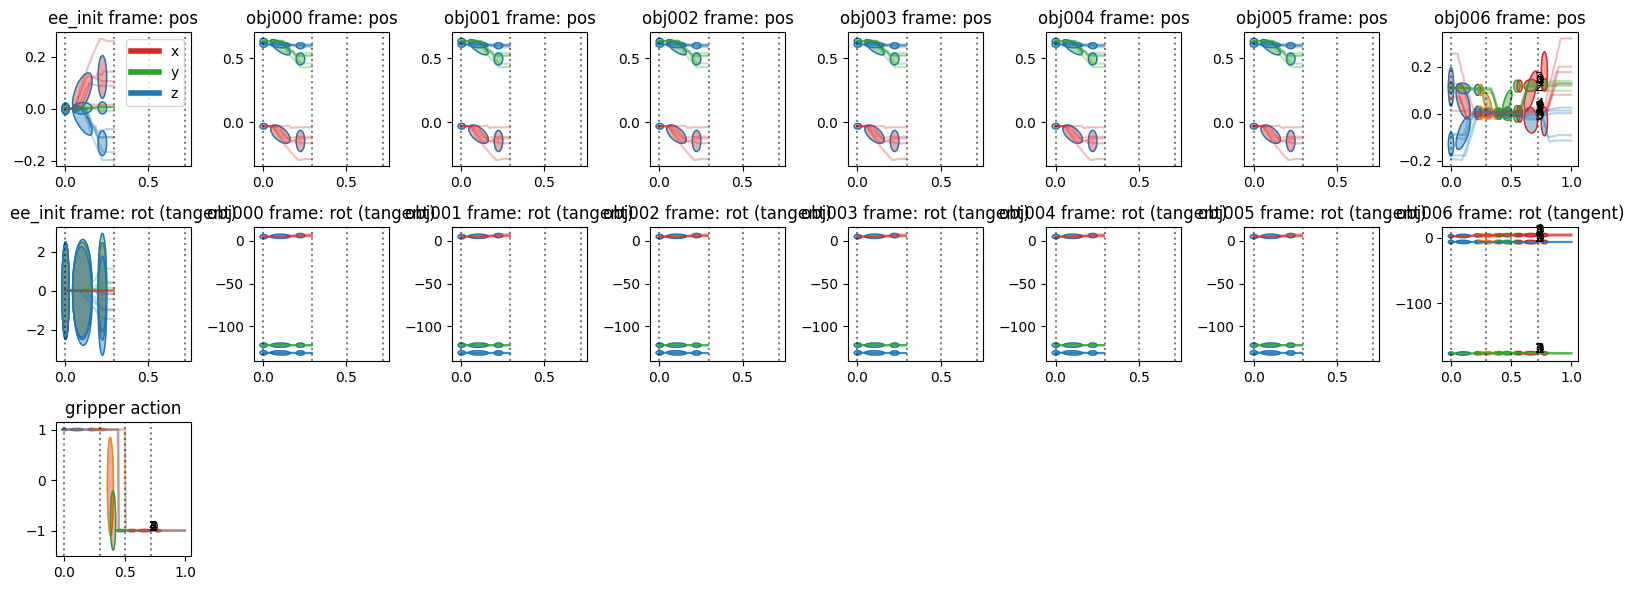

In [9]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=False, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False) #, size=(150, 10))


In [10]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.EM_HMM, ))


2025-08-05 03:29:30.041 | INFO     |  Fitting AutoTPGMM
2025-08-05 03:29:30.043 | INFO     |  Performing fitting actions: [EM_HMM]


Fitting segments:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 03:29:30.083 | INFO     |  HMM EM ...
2025-08-05 03:29:30.121 | INFO     |  HMM transition matrix not defined, initializing to uniform


HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

2025-08-05 03:29:30.453 | INFO     |  HMM init priors not defined, initializing to uniform
2025-08-05 03:29:37.491 | INFO     |  HMM EM converged


HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

((array([[1.78e-008, 6.93e-009, 2.34e-009, 6.73e-010, 1.62e-010, 3.19e-011,
          5.03e-012, 6.26e-013, 5.99e-014, 4.32e-015, 2.30e-016, 8.78e-018,
          1.23e-019, 1.96e-022, 1.12e-026, 7.52e-033, 1.94e-041, 6.58e-053,
          1.01e-067, 3.21e-086, 3.84e-109, 3.14e-137, 3.37e-171, 9.93e-212,
          1.72e-259, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 6.56e-008, 4.13e-008, 2.12e-008,
          8.51e-009, 2.60e-009, 5.87e-010, 9.49e-011, 1.07e-011, 8.28e-013,
          4.26e-014, 1.43e-015, 3.05e-017, 4.06e-019, 3.31e-021, 1.62e-023,
          2.44e-026, 3.52e-030, 1.55e-035, 3.65e-041, 8.28e-049, 5.98e-059,
          4.

2025-08-05 03:29:46.575 | INFO     |  Did not specify time_based, deciding automatically.


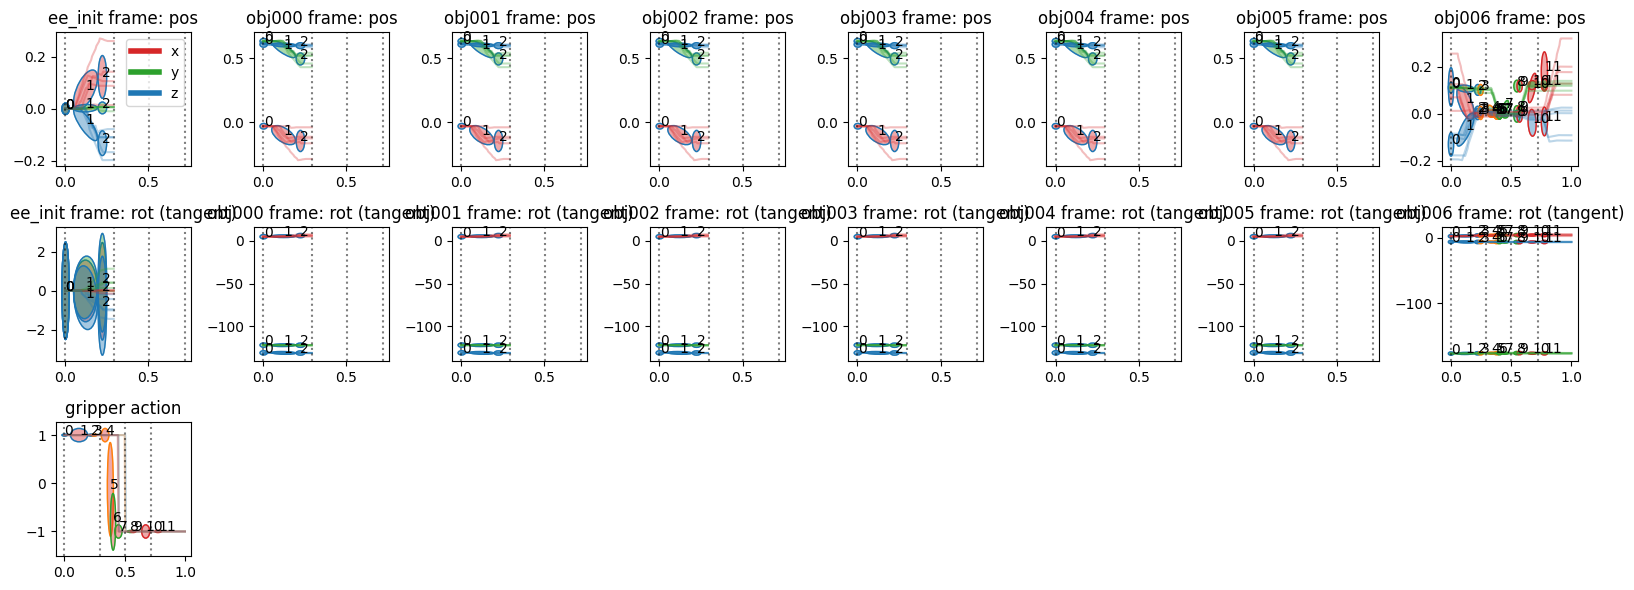

In [11]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False)

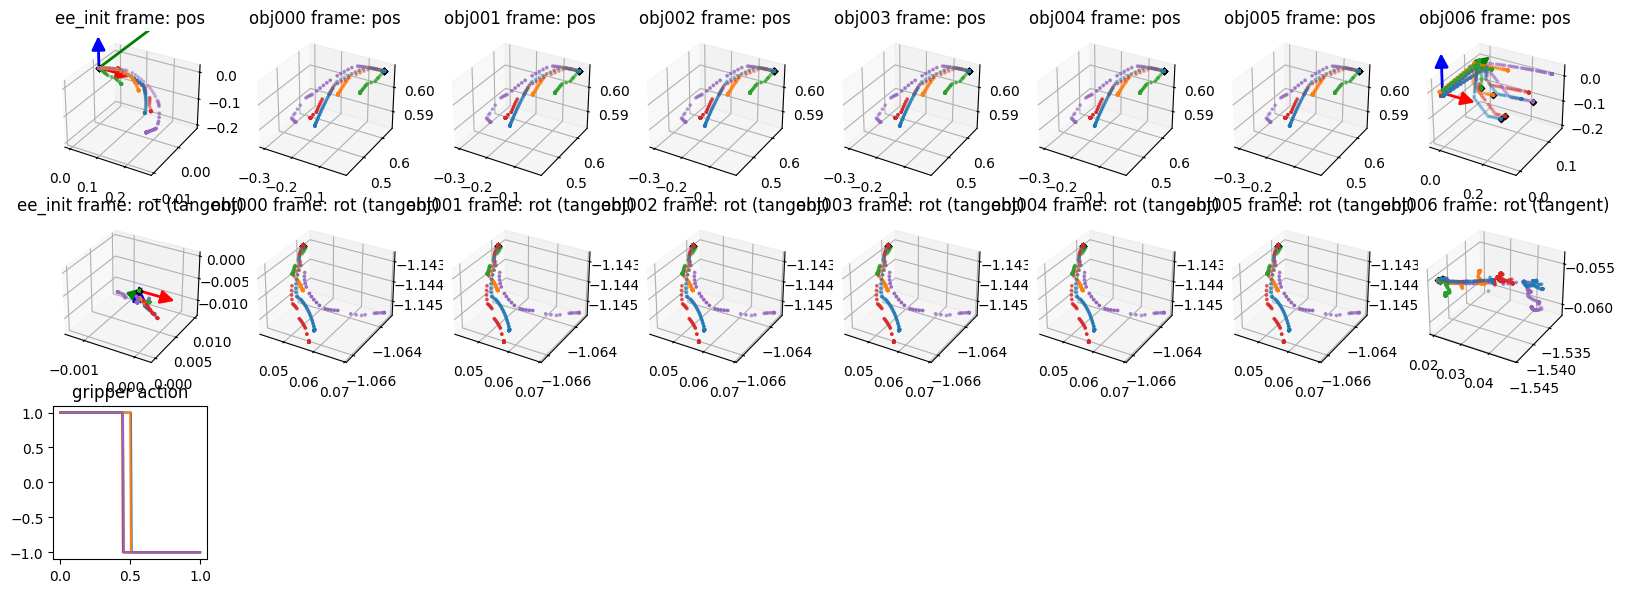

In [12]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False, time_based=False)

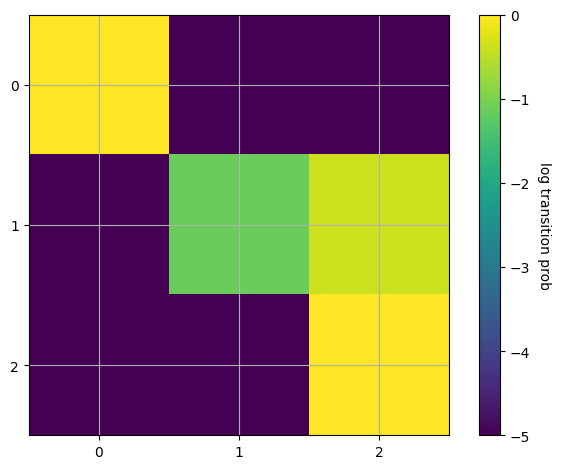

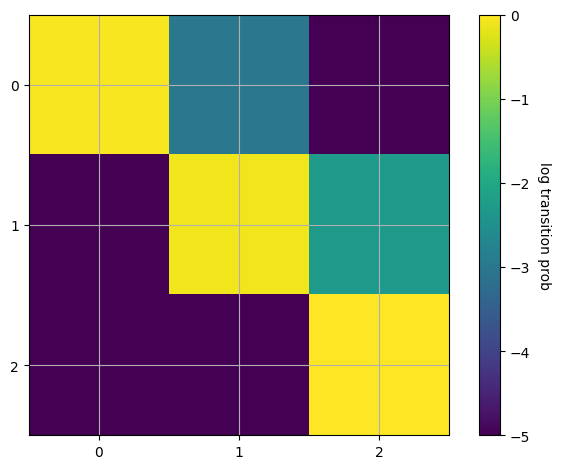

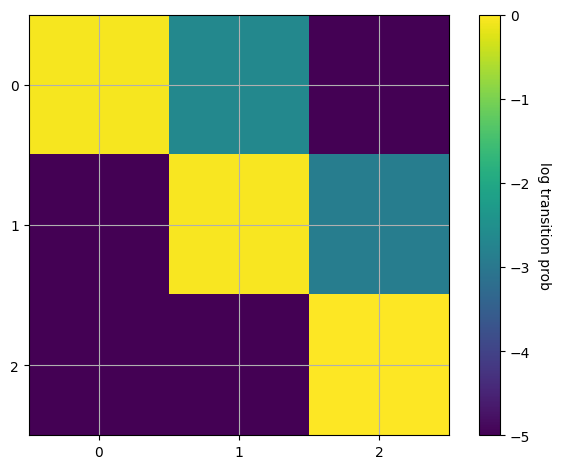

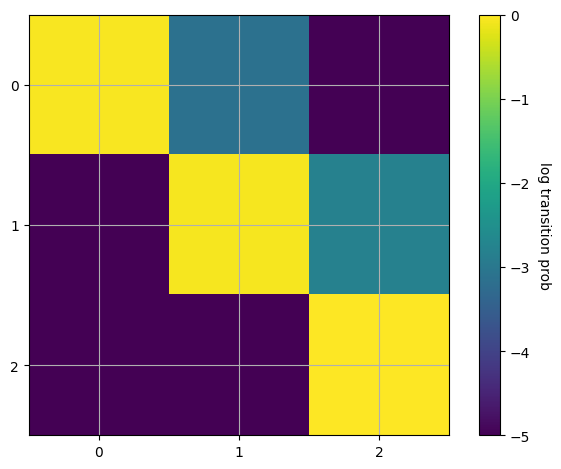

In [13]:
atpgmm.plot_hmm_transition_matrix()

In [14]:
atpgmm.to_disk(data_root / task / 'demos_gmm_policy-release.pt')

2025-08-05 03:30:04.396 | INFO     |  Saving model:


In [15]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2025-08-05 03:30:04.752 | INFO     |  Time-based reconstruction not specified. Auto selected True.
2025-08-05 03:30:04.863 | INFO     |  Caculated segment transition probabilities: (array([[1.]]), array([[1.]]), array([[1.]]))
2025-08-05 03:30:04.864 | INFO     |  Creating partial frame view of demos.
2025-08-05 03:30:04.982 | INFO     |  Assuming zero frame velocity. Should be fixed.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 03:30:06.147 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 03:30:06.222 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 03:30:06.319 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 03:30:06.429 | WARNING  |  Setting init priors of later segments to zero.


GMR:   0%|          | 0/5 [00:00<?, ?it/s]

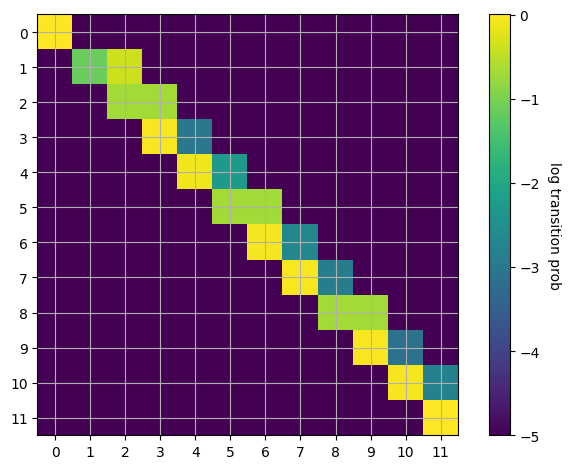

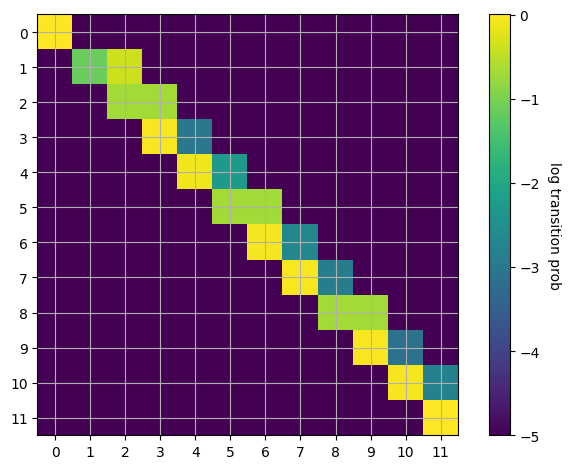

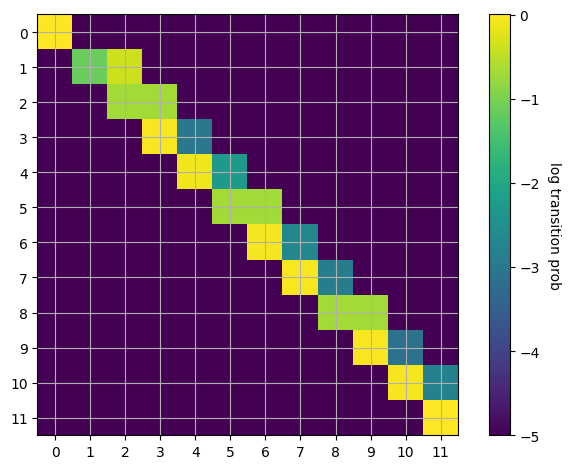

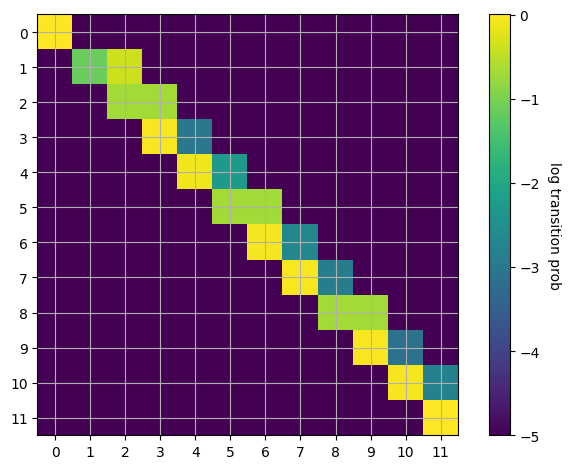

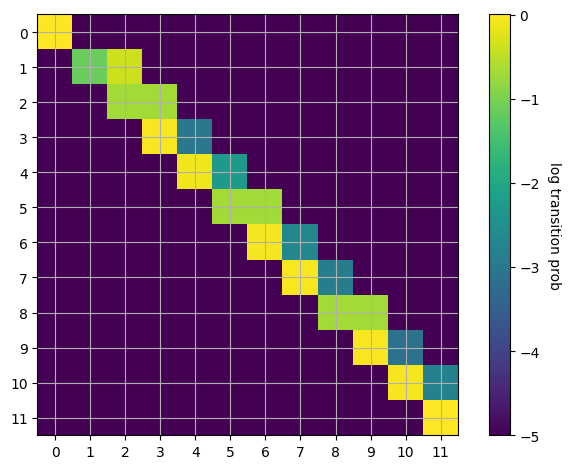

In [16]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)

2025-08-05 03:30:23.419 | INFO     |  Taking frame origins from demos.


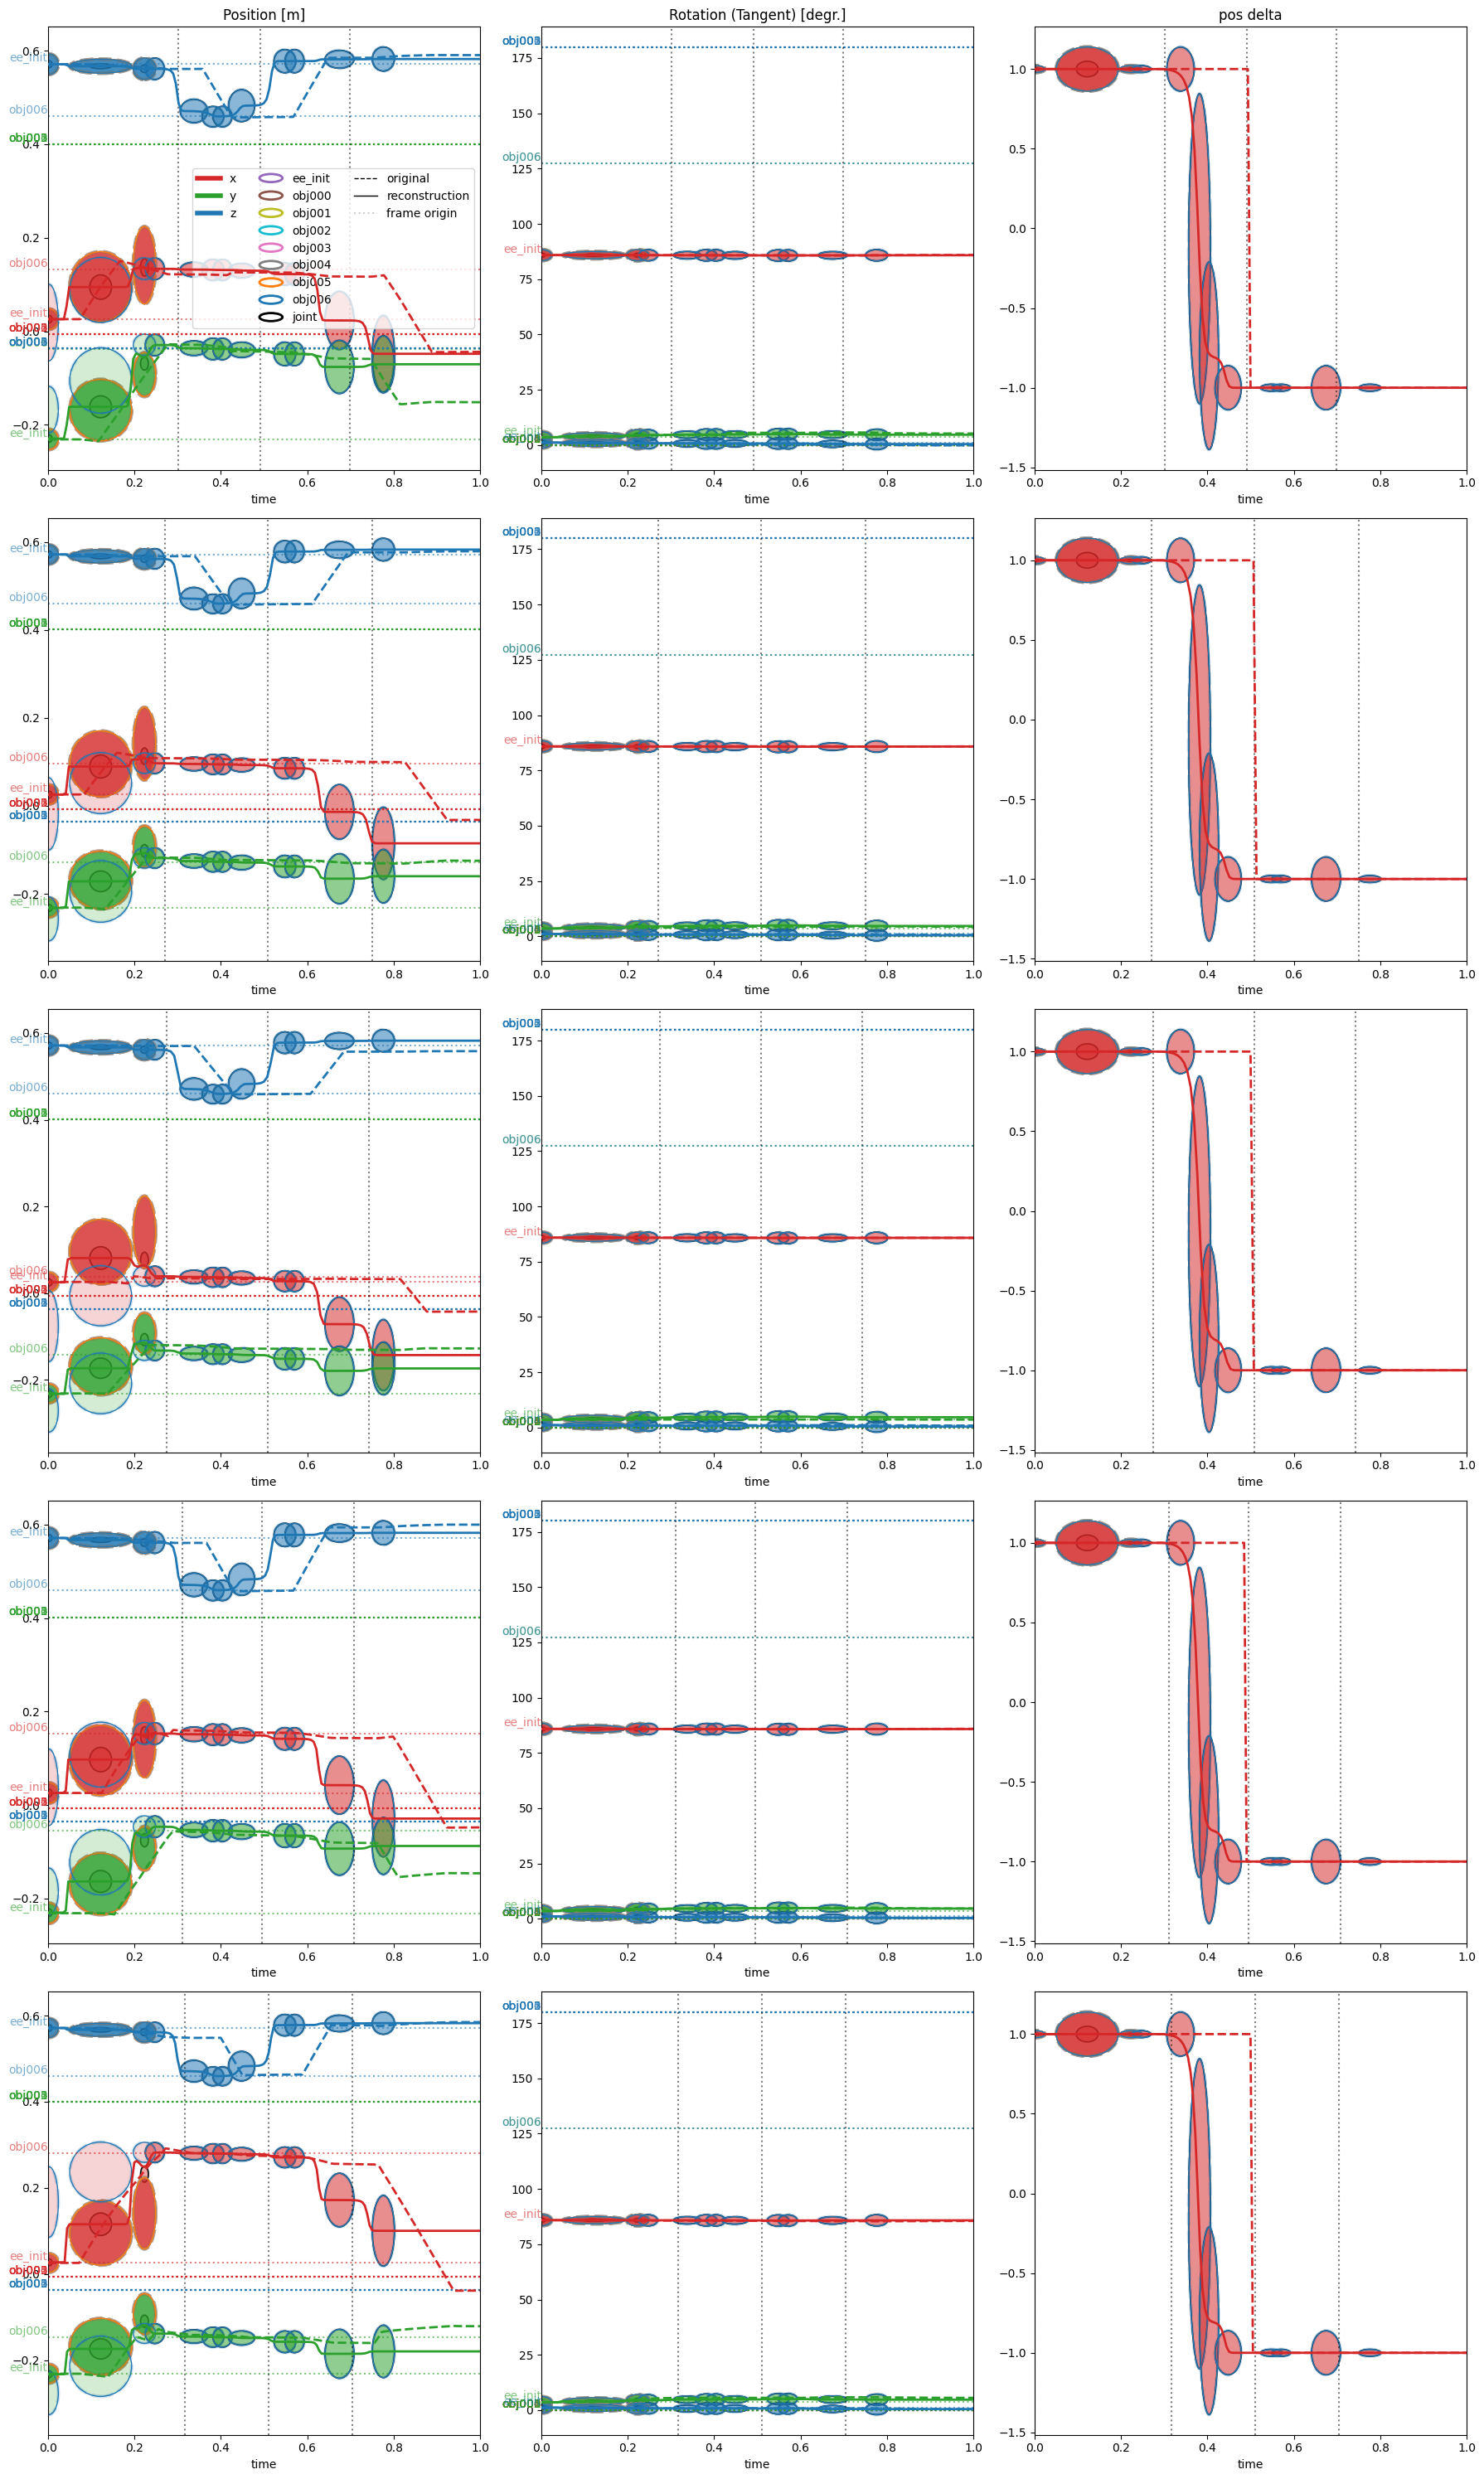

In [17]:

atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=True, equal_aspect=False, per_segment=False)


In [ ]:
atpgmm.plot_reconstructions(
    seg_trans_marginals, seg_joint_models, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=False, equal_aspect=True, per_segment=False)


IndexError: tuple index out of range

: 